## Sentiment analysis for Youtube comments (Vietnamese)

## 1. Import neccessary modules

In [3]:
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pickle
import re
import unicodedata

from sklearn import preprocessing, metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchtext
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER

from vncorenlp import VnCoreNLP

import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

## 2. Load and preprocessing data

In [4]:
df = pd.read_csv("./datasetVie.csv")
df = df.sample(frac = 1)
df

,Comment,Label
1222,Cho e order 1 nồi lẩu ẩm nhạc tẩm đầy ý ngĩa,2
1410,không biết ô ý có nhận con nuôi không nhỉ ?,1
1708,Rất nhiều thông tin bổ ích,2
1678,Không gì sướng hơn vì được đi ăn mà lại qua tậ...,2
683,Anh khoai đi Thailand đi anh,1
...,...,...
824,Cảm ơn Bro ạ hehe,2
2005,giờ lắm bọn biến thái thế,0
2131,Cảm ơn nếu ko ra video lsử chắc em rớt thi học kỳ,2
2338,Nước ngoài dỡ hơn vn mình nhiều đúng ko a...,1


<Axes: xlabel='Label', ylabel='count'>

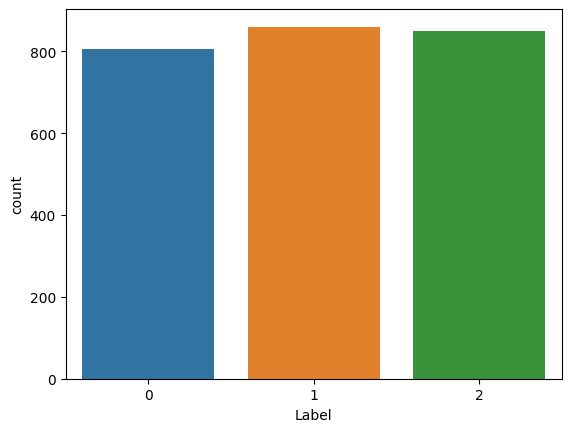

In [5]:
sns.countplot(x='Label', data=df)

In [6]:
# lowercasing
df['Comment'] = df['Comment'].str.lower()

# removing urls
df['Comment'] = df['Comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing commas "\n"
df['Comment'] = df['Comment'].replace('\n','', regex=True)

# removing all the punctuations
df['Comment'] = df['Comment'].str.replace('[^\w\s]','')

# removing integers
#df['Comment'] = df['Comment'].replace('\d','', regex=True)

# removing emojis
#df['Comment'] = df['Comment'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

In [7]:
from autocorrect import Speller

spell = Speller(lang='vi')

def typo_corrector(text):
    return spell(text)

df['Comment'] = df['Comment'].apply(typo_corrector)

In [8]:
# stemming
import nltk
stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df['Comment'] = df['Comment'].apply(stem_text)


# lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df['Comment'] = df['Comment'].apply(lemmatize_text)

In [9]:
# Removing stopwords

def remove_stopwords(text, stopwords):
    # Create a regular expression pattern for stopwords
    pattern = r'\b(?:{})\b'.format('|'.join(stopwords))
    
    # Remove stopwords using regex
    filtered_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    return filtered_text

# Load the stopwords from the file
with open('./vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file]

df['Comment'] = df['Comment'].apply(lambda x: remove_stopwords(x, stopwords))


In [10]:
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg,pos,ner", max_heap_size='-Xmx2g')
for i in range(len(df)):
    df['Comment'][i] = rdrsegmenter.tokenize(df['Comment'][i])
    df['Comment'][i] = ' '.join([' '.join(x) for x in df['Comment'][i]])
df

,Comment,Label
1222,e order 1 nồi lẩu ẩm nhạc tẩm nghĩa,2
1410,ô nuôi ?,1
1708,thông bổ_ích,2
1678,sướng đi tận nhật .. sướng 😀😍😀,2
683,khoai đi thailand đi,1
...,...,...
824,bro her,2
2005,lắm bọn biến_thái,0
2131,ko video sử rớt thi học_kỳ,2
2338,nước ngựài dỡ vn mình nhiều đúng ko ae..k...,1


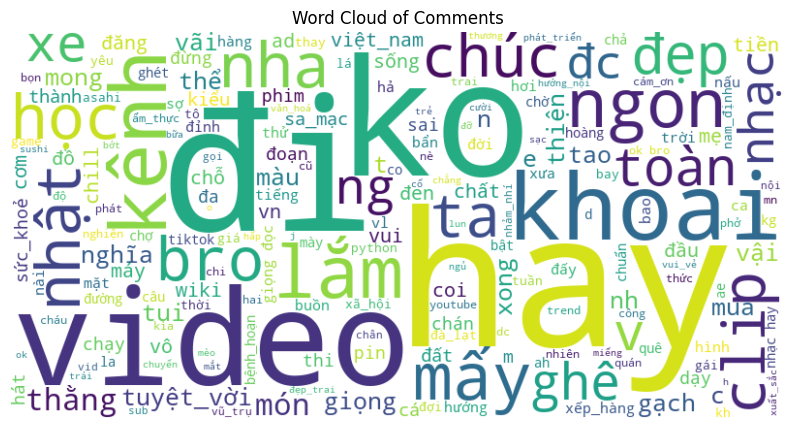

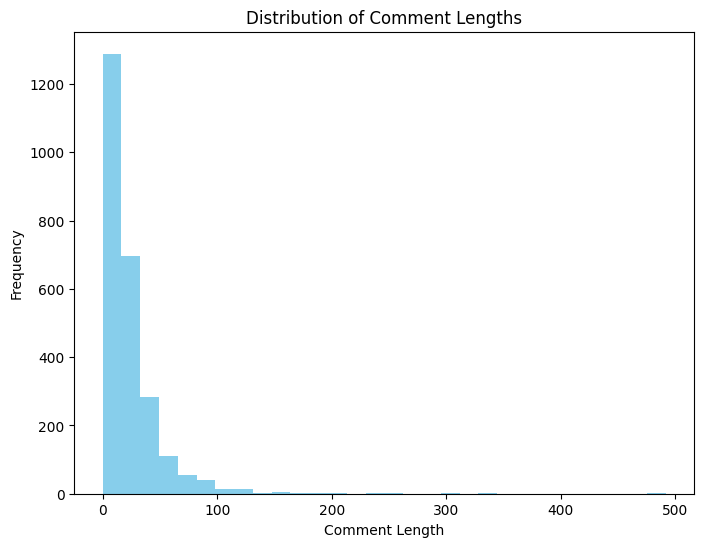

In [11]:
# Concatenate all comments into a single string
comments_text = ' '.join(df['Comment'].values)
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

# Histogram to visualize the length of comments
comment_lengths = df['Comment'].str.len()

plt.figure(figsize=(8, 6))
plt.hist(comment_lengths, bins=30, color='skyblue')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()


## 3. Train SKLearn models

In [12]:
X = df['Comment']
y = df["Label"]

In [13]:
flat_array = X.to_numpy()
flat_array = flat_array.flatten()
vectorizer = TfidfVectorizer (max_features=2500, min_df=0.0, max_df=0.8)
X_vectorized = vectorizer.fit_transform(flat_array)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=0)

In [15]:
# Initialize the classifiers
classifiers = {
    'LinearSVC': LinearSVC(C=1.0, random_state=0),
    'RandomForest': RandomForestClassifier(max_features='log2', n_estimators=1000, criterion = 'entropy', random_state = 0),
    'LogisticRegression': LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', random_state = 0),
    'MultinomialNB': MultinomialNB(alpha=1, fit_prior=False),
    'DecisionTree': DecisionTreeClassifier(criterion='gini', max_features=None,min_samples_leaf=1,min_samples_split=2, random_state=0)
}


# Train and evaluate each model
accuracies = {}
predictions = {}

for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)
    predictions[name] = y_pred.astype(str)

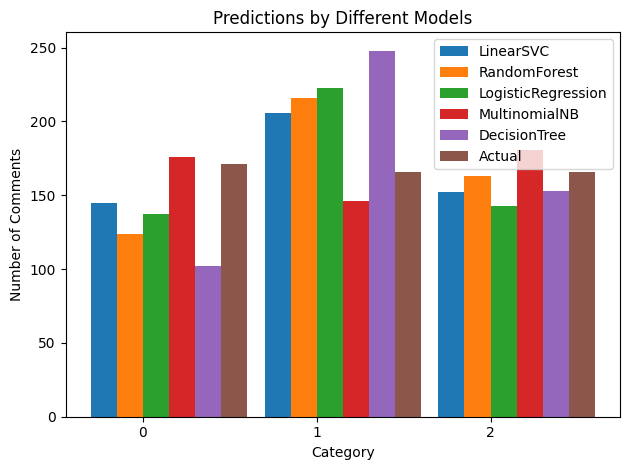

In [16]:
# Get the counts of each category in y_test
unique_labels = np.unique(y_test)
actual_counts = np.bincount(y_test.astype(int), minlength=len(unique_labels))

# Plot the number of comments predicted in each category for all models
categories = ['0', '1', '2']
num_models = len(classifiers)
bar_width = 0.15
index = np.arange(len(categories))
offset = bar_width * ((num_models + 1) / 2)

plt.figure()

# Plot the predictions of each model
for i, (name, preds) in enumerate(predictions.items()):
    counts = np.zeros((len(categories),))
    for j, category in enumerate(categories):
        counts[j] = np.sum(preds == category)
    plt.bar(index + (i * bar_width) - offset, counts, bar_width, label=name)

# Plot the actual counts
plt.bar(index + (num_models * bar_width) - offset, actual_counts, bar_width, label='Actual')

plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.title('Predictions by Different Models')
plt.xticks(index - (offset / 2), unique_labels)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Print the accuracies
for name, accuracy in accuracies.items():
    print(f'{name} Accuracy: {accuracy}')

LinearSVC Accuracy: 0.6998011928429424
RandomForest Accuracy: 0.6679920477137177
LogisticRegression Accuracy: 0.6978131212723658
MultinomialNB Accuracy: 0.7117296222664016
DecisionTree Accuracy: 0.610337972166998


In [18]:
# Print the F1 score
for name, preds in predictions.items():
    preds_str = preds.astype(str)  
    y_test_str = y_test.astype(str)
    f1 = f1_score(y_test_str, preds_str, average='macro')  # Change average as per your requirement
    print(f'{name} F1 Score: {f1}')

LinearSVC F1 Score: 0.7032306002621187
RandomForest F1 Score: 0.6708448449058633
LogisticRegression F1 Score: 0.7016880203292962
MultinomialNB F1 Score: 0.709567969654425
DecisionTree F1 Score: 0.6115080987644704


## 4. Train RoBERTa model

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

<Axes: xlabel='Label', ylabel='count'>

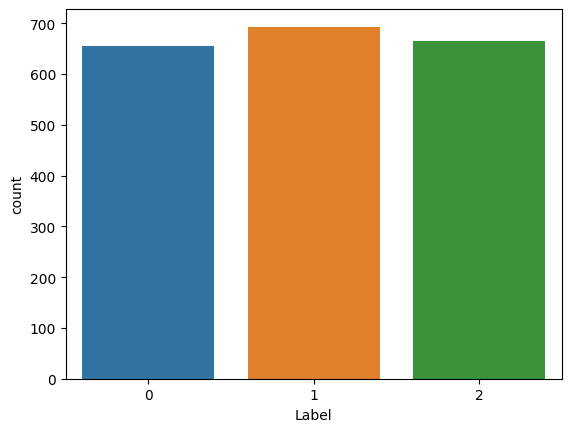

In [18]:
sns.countplot(x='Label', data=train_df)

<Axes: xlabel='Label', ylabel='count'>

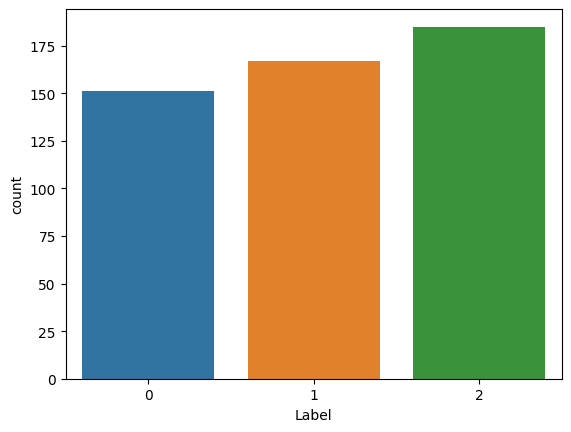

In [19]:
sns.countplot(x='Label', data=test_df)

In [20]:
label_encoder = preprocessing.LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])

In [21]:
class PadTransform(torch.nn.Module):
    """Pad tensor to a fixed length with given padding value.
    :param max_length: Maximum length to pad to
    :type max_length: int
    :param pad_value: Value to pad the tensor with
    :type pad_value: bool
    """

    def __init__(self, max_length: int, pad_value: int) -> None:
        super().__init__()
        self.max_length = max_length
        self.pad_value = float(pad_value)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        :param x: The tensor to pad
        :type x: Tensor
        :return: Tensor padded up to max_length with pad_value
        :rtype: Tensor
        """
        max_encoded_length = x.size(-1)
        if max_encoded_length < self.max_length:
            pad_amount = self.max_length - max_encoded_length
            x = torch.nn.functional.pad(x, (0, pad_amount), value=self.pad_value)
        return x

In [22]:
padding_idx = 1
bos_idx = 0
eos_idx = 2
max_seq_len = 256

text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()

In [23]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(text_transform(self.df.iloc[idx, 0])),
            torch.tensor(self.df.iloc[idx, 1])
        )

train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

In [24]:
SMALL_BATCH_SIZE = 16
K = 2
LARGE_BATCH_SIZE = K * SMALL_BATCH_SIZE

In [25]:
def batch_collate_fn(batch):
    inp_list = list()
    tar_list = list()
    
    for sample in batch:
        inp_list.append(sample[0].tolist())
        tar_list.append(sample[1])
        
    padded_tensor = F.to_tensor(inp_list, padding_value=padding_idx)
    target_tensor = torch.stack(tar_list).type(torch.LongTensor)
    
    return padded_tensor, target_tensor

In [26]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=True,
    collate_fn=batch_collate_fn
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=False,
    collate_fn=batch_collate_fn
)

num_classes = 3
input_dim = 768

In [27]:
classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(DEVICE)
pass  
learning_rate = 1.2e-5 
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = torch.nn.CrossEntropyLoss()

### Train

In [28]:
def train_step(input, target, small_batch_no):
    output = model(input)
    loss = criteria(output, target)
    loss.backward()
    
    if (small_batch_no + 1) % K == 0 or (small_batch_no + 1) == len(train_dataloader):
        optim.step()
        optim.zero_grad()
    
    return loss.item() / input.size(dim=0)

def evaluate():
    model.eval()
    total_loss = 0
    counter = 0
    
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            input = batch[0].clone().detach().to(DEVICE)
            output = model(input)
            target = batch[1].clone().detach().to(DEVICE)
            
            if i == 0:
                class_output = torch.argmax(output, dim=1)
                class_target = target
            else:
                class_output = torch.cat([class_output, torch.argmax(output, dim=1)])
                class_target = torch.cat([class_target, target])
            
            loss = criteria(output, target).item()
            total_loss += loss
            counter += input.size(dim=0)
            
            
        confusion_matrix = metrics.confusion_matrix(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2]
        ) 
        classification_report = metrics.classification_report(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2],
            output_dict=True
        )

    return (
        total_loss,
        counter,
        confusion_matrix,
        classification_report
    )

In [29]:
num_epochs = 20

In [30]:
def save_log(epoch, **kwargs):
    with open(f'log_{epoch}.pkl', 'wb') as f:
        pickle.dump(kwargs, f)

def save_model(message):
    torch.save(model.state_dict(), f'model_{message}.pth')
    print('Model saved successfully')

In [31]:
max_accuracy = float('-inf')
max_macro_f1 = float('-inf')
max_weighted_f1 = float('-inf')

In [32]:
for epoch in range(num_epochs):
    model.train()
    avg_training_losses = list()
    
    for small_batch_no, small_batch in enumerate(train_dataloader):
        input = small_batch[0].clone().detach().to(DEVICE)
        target = small_batch[1].clone().detach().to(DEVICE)
        avg_training_losses.append(
            train_step(input, target, small_batch_no)
        )
        torch.cuda.empty_cache()

    total_loss, counter, confusion_matrix, classification_report = evaluate()
    print(f'EPOCH {epoch}')
    print(f'Mean of avg_training_losses={np.mean(avg_training_losses)}')
    print(f'total_loss={total_loss}')
    print(f'counter={counter}')
    print(f'loss=total_loss/counter={total_loss/counter}')
    print(f'confusion_matrix=\n{confusion_matrix}')
    print('classification_report=')
    pprint.pprint(classification_report)
    
    save_log(
        epoch,
        avg_training_losses=avg_training_losses,
        total_loss=total_loss,
        counter=counter,
        loss=total_loss/counter,
        confusion_matrix=confusion_matrix,
        classification_report=classification_report
    )
    
    if classification_report['accuracy'] > max_accuracy:
        print(f'New max_accuracy')
        max_accuracy = classification_report['accuracy']
        max_accuracy_index = epoch
        save_model('max_accuracy')
        
    elif classification_report['macro avg']['f1-score'] > max_macro_f1:
        print(f'New max_macro_f1')
        max_macro_f1 = classification_report['macro avg']['f1-score']
        max_macro_f1_index = epoch
        save_model('max_macro_f1')
    
    elif classification_report['weighted avg']['f1-score'] > max_weighted_f1:
        print(f'New max_weighted_f1')
        max_weighted_f1 = classification_report['weighted avg']['f1-score']
        max_weighted_f1_index = epoch
        save_model('max_weighted_f1')
    
    elif epoch == num_epochs - 1:
        save_model(f'{epoch}_last')
    
    elif epoch % 40 == 0:
        save_model(f'{epoch}_checkpoint')
        
    else:
        continue

save_log(
    'post_train_info',
    max_accuracy=max_accuracy,
    max_accuracy_index=max_accuracy_index,
    max_macro_f1=max_macro_f1,
    max_macro_f1_index=max_macro_f1_index,
    max_weighted_f1=max_weighted_f1,
    max_weighted_f1_index=max_weighted_f1_index
)

EPOCH 0
Mean of avg_training_losses=0.06888935695249568
total_loss=34.74876844882965
counter=503
loss=total_loss/counter=0.06908303866566531
confusion_matrix=
[[  2 128  21]
 [  0 146  21]
 [  1 128  56]]
classification_report=
{'0': {'f1-score': 0.025974025974025976,
       'precision': 0.6666666666666666,
       'recall': 0.013245033112582781,
       'support': 151},
 '1': {'f1-score': 0.5131810193321616,
       'precision': 0.36318407960199006,
       'recall': 0.874251497005988,
       'support': 167},
 '2': {'f1-score': 0.39575971731448767,
       'precision': 0.5714285714285714,
       'recall': 0.3027027027027027,
       'support': 185},
 'accuracy': 0.40556660039761433,
 'macro avg': {'f1-score': 0.3116382542068918,
               'precision': 0.5337597725657427,
               'recall': 0.3967330776070912,
               'support': 503},
 'weighted avg': {'f1-score': 0.32373529990801014,
                  'precision': 0.5308801067087172,
                  'recall': 0.405566600

Model saved successfully
EPOCH 8
Mean of avg_training_losses=0.04461730073487002
total_loss=23.250682562589645
counter=503
loss=total_loss/counter=0.046224020999184184
confusion_matrix=
[[102  23  26]
 [ 18 115  34]
 [ 11  23 151]]
classification_report=
{'0': {'f1-score': 0.723404255319149,
       'precision': 0.7786259541984732,
       'recall': 0.6754966887417219,
       'support': 151},
 '1': {'f1-score': 0.701219512195122,
       'precision': 0.7142857142857143,
       'recall': 0.688622754491018,
       'support': 167},
 '2': {'f1-score': 0.7626262626262627,
       'precision': 0.7156398104265402,
       'recall': 0.8162162162162162,
       'support': 185},
 'accuracy': 0.731610337972167,
 'macro avg': {'f1-score': 0.7290833433801779,
               'precision': 0.7361838263035759,
               'recall': 0.7267785531496521,
               'support': 503},
 'weighted avg': {'f1-score': 0.730464333351164,
                  'precision': 0.734098604967383,
                  'recall

Model saved successfully
EPOCH 16
Mean of avg_training_losses=0.029314851422828657
total_loss=23.383248895406723
counter=503
loss=total_loss/counter=0.046487572356673404
confusion_matrix=
[[105  27  19]
 [ 20 121  26]
 [ 13  22 150]]
classification_report=
{'0': {'f1-score': 0.7266435986159171,
       'precision': 0.7608695652173914,
       'recall': 0.695364238410596,
       'support': 151},
 '1': {'f1-score': 0.7181008902077153,
       'precision': 0.711764705882353,
       'recall': 0.7245508982035929,
       'support': 167},
 '2': {'f1-score': 0.7894736842105263,
       'precision': 0.7692307692307693,
       'recall': 0.8108108108108109,
       'support': 185},
 'accuracy': 0.7475149105367793,
 'macro avg': {'f1-score': 0.7447393910113863,
               'precision': 0.7472883467768378,
               'recall': 0.7435753158083332,
               'support': 503},
 'weighted avg': {'f1-score': 0.7469158322756247,
                  'precision': 0.7476415557412949,
                  '

In [33]:
max_accuracy
# max_accuracy_index
# max_macro_f1
# max_macro_f1_index
# max_weighted_f1
# max_weighted_f1_index

0.7733598409542743

### Predict

In [34]:
def prepare_model():
    num_classes = 3
    input_dim = 768

    classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
    model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
    
    DEMO_MODEL_PATH = 'model_max_accuracy.pth'
    model.load_state_dict(torch.load(DEMO_MODEL_PATH))
    model.to(DEVICE)
    
    print(f'Loaded model to [{DEVICE}] in [{DEMO_MODEL_PATH}]')
    return model

def prepare_text_transform():
    text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()
    return text_transform

def predict(sentence, model, text_transform, label_map):
    transformed_text = text_transform(sentence)
    out = model(torch.tensor([transformed_text]).to(DEVICE))
    return label_map[torch.argmax(out).item()]

label_map = {
    0: 0,
    1: 1,
    2: 2
}

model = prepare_model()
text_transform = prepare_text_transform()

Loaded model to [cpu] in [model_max_accuracy.pth]


In [35]:
neg = 0
neu = 0
pos = 0

for index, row in test_df.iterrows():
    comment = row['Comment']
    actual_label = row['Label']
    prediction = predict(comment, model, text_transform, label_map)  
    if prediction != actual_label:
        print(comment)
        print(prediction)
        print(actual_label)
        print()

    if prediction == 0:
        neg = neg + 1
    elif prediction == 1:
        neu = neu + 1
    elif prediction == 2:
        pos = pos + 1


học bật chấm
0
2

đăng_kiểm
0
1

dõi đa fake hướng nội😮
0
1

all
2
1

xếp_hàng khu ẩm_thực nổi_tiếng - an_toàn thực_phẩm - giá - ngon_miệng vn kinh_doanh mô_hình kd quản_lý chặt_chẽ cậi
0
1

cảnh quê yên_bình bình . hùng video tuyệt , chia video đất việt_nam ,
1
2

thể hay im_lặng đừng sống lặng_im 👏👏👏👏👏
2
1

trẻ bay màu = )
1
0

chủ quán chuc gđ sk
1
2

viết bàn giới cực_lạc .
0
1

coi them
1
2

hello khoai hôm muộn 💓💓💓
1
2

cám_ơn
0
2

dạy thực chiến ko nuda bạc hơi phí hoàng 😊
1
2

đọc mệt
2
0

si giọng đọc thương đấi
0
2

đặc cầu
1
0

choi ti tok
2
0

hai
2
0

minh rat thực ma nguoi lam bay
0
2

trông ô_uế vãi
1
0

lực vãi ò
1
2

đẹp
2
0

one
1
2

khoai_lang thang clip đi info haytaiwan , thailand .. nhàn_nhạt kênh du_lịch vẩy youtube ..
1
0

vn 1 ngài nhật z khoai
1
0

nguoi thu thach xinh ton o day thu coi
2
1

gái độc_thoại_thể đọc thoại phim gái
1
2

giọng đọc vầy gọi giới động_vật .. mấy kênh toàn lồng_tiếng tấu hài chán .. like + sub admin
0
2

lí tui xoá tiktok , ngán .
1
0


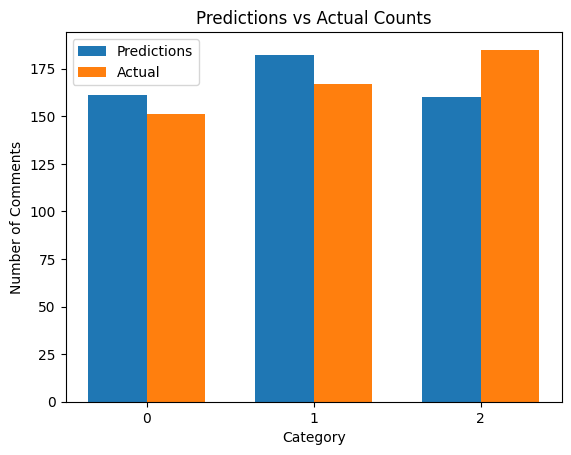

In [36]:
# Get the actual counts from the 'Label' column in `test_df`
actual_counts = test_df['Label'].value_counts().sort_index()

# Define the categories and their corresponding indices
categories = ['0', '1', '2']
indices = np.arange(len(categories))

# Set the width of each bar
bar_width = 0.35

# Plot the predictions and actual counts
plt.bar(indices, [neg, neu, pos], bar_width, label='Predictions')
plt.bar(indices + bar_width, actual_counts, bar_width, label='Actual')

# Add labels, title, and ticks
plt.xlabel('Category')
plt.ylabel('Number of Comments')
plt.title('Predictions vs Actual Counts')
plt.xticks(indices + bar_width/2, categories)
plt.legend()

# Display the graph
plt.show()

In [54]:
sample_text = 'cảm ơn đã đọc!'
sample_text = rdrsegmenter.tokenize(sample_text)
sample_text = ' '.join([' '.join(x) for x in sample_text])
print(sample_text)
predict(sample_text, model, text_transform, label_map)

cảm_ơn đã đọc !


2